# Reward + Cost Temporal Discounting Model

This notebook implements an enhanced model for temporal discounting using memo that includes:
- **Cost term** based on user perceptions of task difficulty, duration, and concreteness
- **Temporal discounting** applied to both reward and cost terms (present bias)
- Comparison of using **perceived vs intended** values for reward

**Model:**
- For each participant p and task j, discrete distribution over lateness l ∈ {0,1,2,3,4,5}
- Early/on-time completions are collapsed into a single bin (l = 0)
- Utility: U_pj(l) = beta_p * reward_discounted - alpha_p * cost_discounted
  - reward_discounted = reward * (gamma_r ** l)
  - cost_discounted = cost * (gamma_c ** l)
  - cost = w_difficulty * perceived_difficulty + w_duration * perceived_duration - w_concreteness * perceived_concreteness
- Convert utilities to probabilities with softmax
- Priors: beta_p ~ Normal(0,5) via softplus, alpha_p ~ Normal(0,5) via softplus
- Cost weights: w_difficulty, w_duration, w_concreteness (can be fixed or inferred)
- Discount factors: gamma_r = 0.9 (reward), gamma_c = 0.9 (cost) - can be different to model different discounting
- MAP inference for each participant's beta_p and alpha_p using memo


In [1]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from enum import IntEnum
from typing import no_type_check
import jax
import jax.numpy as jnp
from memo import memo

# Set random seed for reproducibility
np.random.seed(42)
jax.config.update("jax_enable_x64", True)

# Set up paths
# Try to find project root by looking for data/ directory
current_dir = Path.cwd()
if (current_dir / 'data').exists():
    PROJECT_ROOT = current_dir
elif (current_dir.parent / 'data').exists():
    PROJECT_ROOT = current_dir.parent
elif (current_dir.parent.parent / 'data').exists():
    PROJECT_ROOT = current_dir.parent.parent
else:
    PROJECT_ROOT = current_dir  # Fallback to current directory

# Create plots directory
PLOTS_DIR = PROJECT_ROOT / 'plots'
PLOTS_DIR.mkdir(exist_ok=True)
print(f"Project root: {PROJECT_ROOT}")
print(f"Plots will be saved to: {PLOTS_DIR}")


Project root: c:\Users\akato\OneDrive\Desktop\Comp Cog Sci\final_project\ccs-final-project
Plots will be saved to: c:\Users\akato\OneDrive\Desktop\Comp Cog Sci\final_project\ccs-final-project\plots


In [2]:
# Data loading and preprocessing
df = pd.read_csv(PROJECT_ROOT / 'data' / 'aggregated_data.csv')

# Filter for completed tasks only (where days_late is not NaN)
df_completed = df[df['completed'] == True].copy()
df_completed = df_completed[df_completed['days_late'].notna()].copy()

# Collapse early/on-time into single bin: lateness = max(0, days_late)
# Clip to [-5, 5] range first, then map negative values to 0
df_completed['days_late_clipped'] = df_completed['days_late'].clip(-5, 5).astype(int)
df_completed['lateness_bin'] = df_completed['days_late_clipped'].apply(lambda x: max(0, x))

# Convert categorical task attributes to numerical if needed
# For now, we'll use perceived values which are already numeric
# But let's also create numerical versions of intended values for comparison
def convert_to_numeric(value, mapping):
    """Convert categorical to numeric using mapping."""
    if pd.isna(value):
        return np.nan
    if isinstance(value, (int, float)):
        return float(value)
    return mapping.get(str(value).lower(), np.nan)

# Create mappings for intended values (for comparison)
concreteness_map = {'high': 8.0, 'medium': 5.0, 'low': 2.0}
difficulty_map = {'easy': 2.0, 'medium': 5.0, 'hard': 8.0}
duration_map = {'short': 2.0, 'medium': 5.0, 'long': 8.0}

df_completed['task_concreteness_num'] = df_completed['task_concreteness'].apply(
    lambda x: convert_to_numeric(x, concreteness_map)
)
df_completed['task_difficulty_num'] = df_completed['task_difficulty'].apply(
    lambda x: convert_to_numeric(x, difficulty_map)
)
df_completed['task_duration_num'] = df_completed['task_duration'].apply(
    lambda x: convert_to_numeric(x, duration_map)
)

print(f"Total completed tasks: {len(df_completed)}")
print(f"Unique participants: {df_completed['participant_id'].nunique()}")
print(f"Unique tasks: {df_completed['task'].nunique()}")
print(f"\nOriginal days late distribution:")
print(df_completed['days_late_clipped'].value_counts().sort_index())
print(f"\nCollapsed lateness bin distribution:")
print(df_completed['lateness_bin'].value_counts().sort_index())
print(f"\nSample of data with perceived values:")
print(df_completed[['participant_id', 'task', 'task_points', 'perceived_reward', 
                    'perceived_difficulty', 'perceived_duration', 'perceived_concreteness',
                    'days_late_clipped', 'lateness_bin']].head(10))


Total completed tasks: 16
Unique participants: 5
Unique tasks: 6

Original days late distribution:
days_late_clipped
-5    2
-3    3
-1    2
 0    5
 1    2
 2    1
 4    1
Name: count, dtype: int64

Collapsed lateness bin distribution:
lateness_bin
0    12
1     2
2     1
4     1
Name: count, dtype: int64

Sample of data with perceived values:
   participant_id                                    task  task_points  \
0         wagtail                    Sort a deck of cards            5   
1         wagtail                   Complete a short quiz            5   
5         wagtail                    Solve a logic puzzle           15   
14   gila monster  Explain a difficult concept from class           20   
16        aphid-1                    Sort a deck of cards            5   
17        aphid-1                   Complete a short quiz            5   
19        aphid-1                Write a brief reflection           15   
21        aphid-1                    Solve a logic puzzle    

In [3]:
# Define lateness bins: {0, 1, 2, 3, 4, 5}
# 0 = early/on-time (collapsed), 1-5 = days late
class LatenessBin(IntEnum):
    """Lateness bins from 0 to 5 days."""
    DAYS_0 = 0      # 0 days (early/on-time, collapsed)
    DAYS_1 = 1      # 1 day late
    DAYS_2 = 2      # 2 days late
    DAYS_3 = 3      # 3 days late
    DAYS_4 = 4      # 4 days late
    DAYS_5 = 5      # 5 days late

# Map from enum index to actual lateness value
# Since enum values start at 0, the index directly maps to lateness
LATENESS_VALUES = np.array([0, 1, 2, 3, 4, 5])


In [4]:
# Memo model definition with cost and temporal discounting
# Utility: U_pj(l) = beta_p * reward_discounted - alpha_p * cost_discounted
# reward_discounted = reward * (gamma_r ** l)
# cost_discounted = cost * (gamma_c ** l)
# cost = w_difficulty * perceived_difficulty + w_duration * perceived_duration - w_concreteness * perceived_concreteness
# 
# Note: In memo, l is an enum index (0-5) which directly maps to lateness
# l=0 -> lateness=0 (early/on-time), l=1 -> lateness=1, etc.
# Since all bins are >= 0, discount = gamma^l for all bins
# 
# Use literal values for gamma_r and gamma_c in expressions (memo doesn't recognize module constants)

# ruff: noqa
@no_type_check
@memo
def reward_cost_temporal_discounting_model[l: LatenessBin](
    beta, alpha, reward, cost, gamma_r, gamma_c
):
    """
    Memo model for temporal discounting with cost.
    
    Args:
        l: Lateness bin (axis) - enum index (0-5) mapping to 0 to 5 days late
        beta: Participant's reward sensitivity parameter (parameter)
        alpha: Participant's cost sensitivity parameter (parameter)
        reward: Reward value for the task (parameter)
        cost: Cost value for the task (parameter)
        gamma_r: Discount factor for reward (parameter)
        gamma_c: Discount factor for cost (parameter)
    
    Returns:
        Probability of choosing lateness bin l
    """
    # Utility = beta * discounted_reward - alpha * discounted_cost
    # Discounted reward = reward * (gamma_r^l)
    # Discounted cost = cost * (gamma_c^l)
    # Since all bins are >= 0, discount = gamma^l for all bins
    # Put entire utility expression directly in wpp (memo syntax requirement)
    participant: chooses(l in LatenessBin, wpp=exp(
        beta * reward * (gamma_r ** l) - 
        alpha * cost * (gamma_c ** l)
    ))
    return Pr[participant.l == l]


In [5]:
# Test the model
print("Testing model...")
test_result = reward_cost_temporal_discounting_model(
    beta=1.0, alpha=0.5, reward=10.0, cost=5.0, gamma_r=0.9, gamma_c=0.9
)
print(f"Model output shape: {test_result.shape}")
print(f"Probabilities sum to: {test_result.sum():.6f}")
print(f"Probabilities for each lateness bin:")
for i, prob in enumerate(test_result):
    lateness = LATENESS_VALUES[i]
    print(f"  {lateness} days: {prob:.4f}")
print("Model works!")


Testing model...
Model output shape: (6,)
Probabilities sum to: 1.000000
Probabilities for each lateness bin:
  0 days: 0.5086
  1 days: 0.2403
  2 days: 0.1223
  3 days: 0.0666
  4 days: 0.0386
  5 days: 0.0236
Model works!


In [6]:
# Helper function to compute cost from perceived values
def compute_cost(perceived_difficulty, perceived_duration, perceived_concreteness,
                 w_difficulty=1.0, w_duration=1.0, w_concreteness=0.5):
    """
    Compute cost from perceived task attributes.
    
    Args:
        perceived_difficulty: Perceived difficulty (1-10 scale)
        perceived_duration: Perceived duration (1-10 scale)
        perceived_concreteness: Perceived concreteness (1-10 scale, higher = more concrete = lower cost)
        w_difficulty: Weight for difficulty
        w_duration: Weight for duration
        w_concreteness: Weight for concreteness (subtracted, so higher concreteness = lower cost)
    
    Returns:
        Cost value
    """
    cost = (w_difficulty * perceived_difficulty + 
            w_duration * perceived_duration - 
            w_concreteness * perceived_concreteness)
    return max(0.0, cost)  # Ensure non-negative cost


In [7]:
# Inference for beta_p and alpha_p using MAP estimation
# Prior: beta_raw ~ Normal(0, 5), alpha_raw ~ Normal(0, 5)
# Then beta = softplus(beta_raw), alpha = softplus(alpha_raw) to ensure >= 0
# Log-likelihood: sum over tasks of log P(l_observed | beta_p, alpha_p, reward_j, cost_j)

def softplus(x):
    """Softplus function: log(1 + exp(x)). Ensures output >= 0."""
    return jnp.log(1 + jnp.exp(x))

def compute_log_likelihood(params, reward_array, cost_array, lateness_bin_array, gamma_r, gamma_c):
    """
    Compute negative log-likelihood for a participant (JAX-compatible).
    
    Args:
        params: Array [beta_raw, alpha_raw]
        reward_array: Array of reward values for each task
        cost_array: Array of cost values for each task
        lateness_bin_array: Array of observed lateness bins (0-5) for each task
        gamma_r: Discount factor for reward
        gamma_c: Discount factor for cost
    
    Returns:
        Negative log-likelihood (for minimization)
    """
    # Transform parameters to ensure >= 0
    beta_raw, alpha_raw = params[0], params[1]
    beta = softplus(beta_raw)
    alpha = softplus(alpha_raw)
    
    # Prior terms: log P(beta_raw) + log P(alpha_raw) = log N(0, 5) for each
    prior_mean = 0.0
    prior_std = 5.0
    prior_term = (-0.5 * ((beta_raw - prior_mean) / prior_std) ** 2 +
                  -0.5 * ((alpha_raw - prior_mean) / prior_std) ** 2)
    
    # Likelihood term: sum of log probabilities
    log_likelihood = 0.0
    for i in range(len(reward_array)):
        reward = float(reward_array[i])
        cost = float(cost_array[i])
        lateness_bin = int(lateness_bin_array[i])
        # Get model probabilities
        probs = reward_cost_temporal_discounting_model(
            beta, alpha, reward, cost, gamma_r, gamma_c
        )
        # lateness_bin directly maps to enum index (0-5)
        prob = probs[lateness_bin]
        log_likelihood += jnp.log(prob + 1e-10)  # Add small epsilon for numerical stability
    
    # Return negative log-likelihood (for minimization)
    return -(prior_term + log_likelihood)

# Fit beta and alpha for each participant using JAX gradients
from scipy.optimize import minimize

participants = df_completed['participant_id'].unique()
beta_estimates = {}
alpha_estimates = {}

# Cost weights (can be tuned or inferred)
# NOTE: If you've run the optimization cells (cells 14-17), you can update these
# to use the optimized values found there. Alternatively, run cell 20 after optimization
# to automatically update the model with optimized weights.
w_difficulty = 1.0
w_duration = 1.0
w_concreteness = 0.5  # Higher concreteness reduces cost

# If optimized weights exist from previous runs, uncomment to use them:
# if 'opt_w_d' in globals():
#     w_difficulty = opt_w_d
#     w_duration = opt_w_dur
#     w_concreteness = opt_w_c
#     print(f"Using optimized weights: w_d={w_difficulty:.4f}, w_dur={w_duration:.4f}, w_c={w_concreteness:.4f}")

# Discount factors
gamma_r = 0.9  # Reward discount factor
gamma_c = 0.9  # Cost discount factor (can be different to model asymmetric discounting)

# Create JAX-compatible objective function with gradients
compute_loss_and_grad = jax.value_and_grad(compute_log_likelihood)

print("Fitting beta and alpha for each participant...")
print(f"Using cost weights: w_difficulty={w_difficulty}, w_duration={w_duration}, w_concreteness={w_concreteness}")
print(f"Using discount factors: gamma_r={gamma_r}, gamma_c={gamma_c}\n")

for participant_id in participants:
    participant_df = df_completed[df_completed['participant_id'] == participant_id].copy()
    
    # Compute cost for each task using perceived values
    costs = []
    rewards = []
    for _, row in participant_df.iterrows():
        cost = compute_cost(
            row['perceived_difficulty'],
            row['perceived_duration'],
            row['perceived_concreteness'],
            w_difficulty, w_duration, w_concreteness
        )
        costs.append(cost)
        # Use perceived reward (can also try task_points for comparison)
        rewards.append(row['perceived_reward'])
    
    reward_array = np.array(rewards)
    cost_array = np.array(costs)
    lateness_bin_array = participant_df['lateness_bin'].values
    
    # Objective function for scipy.optimize
    def objective(x):
        loss, grad = compute_loss_and_grad(
            x, reward_array, cost_array, lateness_bin_array, gamma_r, gamma_c
        )
        return float(loss), np.array([float(grad[0]), float(grad[1])])
    
    # Initialize beta_raw and alpha_raw at 0 (maps to beta ≈ 0.693, alpha ≈ 0.693)
    result = minimize(
        objective,
        x0=[0.0, 0.0],
        method='L-BFGS-B',
        jac=True
    )
    
    beta_raw = result.x[0]
    alpha_raw = result.x[1]
    beta = float(softplus(beta_raw))
    alpha = float(softplus(alpha_raw))
    beta_estimates[participant_id] = beta
    alpha_estimates[participant_id] = alpha
    
    print(f"  {participant_id}:")
    print(f"    beta_raw = {beta_raw:.3f}, beta = {beta:.3f}")
    print(f"    alpha_raw = {alpha_raw:.3f}, alpha = {alpha:.3f}")

print(f"\nFitted {len(beta_estimates)} participants")


Fitting beta and alpha for each participant...
Using cost weights: w_difficulty=1.0, w_duration=1.0, w_concreteness=0.5
Using discount factors: gamma_r=0.9, gamma_c=0.9

  wagtail:
    beta_raw = 4.320, beta = 4.333
    alpha_raw = -1.048, alpha = 0.301
  gila monster:
    beta_raw = 3.191, beta = 3.232
    alpha_raw = -0.782, alpha = 0.377
  aphid-1:
    beta_raw = 6.222, beta = 6.224
    alpha_raw = -0.212, alpha = 0.593
  kingfisher:
    beta_raw = 5.648, beta = 5.652
    alpha_raw = -1.141, alpha = 0.277
  aphid-2:
    beta_raw = 1.411, beta = 1.629
    alpha_raw = 0.404, alpha = 0.916

Fitted 5 participants


In [8]:
# Posterior predictions for individual participants
# For each participant-task combination, compute:
# - Observed days_late
# - Model-predicted expected days_late (E[l] = sum(days_late * P(l)))

participant_task_stats = []

for _, row in df_completed.iterrows():
    participant_id = row['participant_id']
    task = row['task']
    reward = row['perceived_reward']
    cost = compute_cost(
        row['perceived_difficulty'],
        row['perceived_duration'],
        row['perceived_concreteness'],
        w_difficulty, w_duration, w_concreteness
    )
    observed_lateness_bin = row['lateness_bin']
    
    # Model-predicted expected lateness for this participant
    beta = beta_estimates[participant_id]
    alpha = alpha_estimates[participant_id]
    probs = reward_cost_temporal_discounting_model(
        beta, alpha, float(reward), float(cost), gamma_r, gamma_c
    )
    # Compute expected value: E[l] = sum(lateness * P(l))
    predicted_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
    
    participant_task_stats.append({
        'participant_id': participant_id,
        'task': task,
        'reward': reward,
        'cost': cost,
        'observed_lateness': observed_lateness_bin,
        'predicted_lateness': predicted_lateness
    })

df_individual = pd.DataFrame(participant_task_stats)
print("Individual participant-task predictions:")
print(df_individual)

# Compute task-level means for aggregated plots
tasks = df_completed['task'].unique()
task_stats = []

for task in tasks:
    task_df = df_completed[df_completed['task'] == task]
    
    # Mean observed lateness across participants
    mean_observed = task_df['lateness_bin'].mean()
    
    # Model-predicted expected days_late (averaged across participants)
    predicted_expected = []
    for participant_id in task_df['participant_id'].unique():
        row = task_df[task_df['participant_id'] == participant_id].iloc[0]
        reward = row['perceived_reward']
        cost = compute_cost(
            row['perceived_difficulty'],
            row['perceived_duration'],
            row['perceived_concreteness'],
            w_difficulty, w_duration, w_concreteness
        )
        beta = beta_estimates[participant_id]
        alpha = alpha_estimates[participant_id]
        probs = reward_cost_temporal_discounting_model(
            beta, alpha, float(reward), float(cost), gamma_r, gamma_c
        )
        expected_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
        predicted_expected.append(expected_lateness)
    
    mean_predicted = np.mean(predicted_expected) if predicted_expected else 0.0
    
    task_stats.append({
        'task': task,
        'mean_observed': mean_observed,
        'mean_predicted': mean_predicted
    })

df_predictions = pd.DataFrame(task_stats)
print("\nTask-level predictions (means):")
print(df_predictions)


Individual participant-task predictions:
   participant_id                                    task  reward  cost  \
0         wagtail                    Sort a deck of cards     3.0   0.0   
1         wagtail                   Complete a short quiz     2.0   1.0   
2         wagtail                    Solve a logic puzzle     5.0   9.5   
3    gila monster  Explain a difficult concept from class     6.0   4.5   
4         aphid-1                    Sort a deck of cards     1.0   0.0   
5         aphid-1                   Complete a short quiz     2.0   0.0   
6         aphid-1                Write a brief reflection     4.0   0.5   
7         aphid-1                    Solve a logic puzzle     8.0   4.5   
8         aphid-1  Explain a difficult concept from class     8.0   8.5   
9      kingfisher                   Complete a short quiz     2.0   1.5   
10     kingfisher                    Draw for ten minutes     3.0   3.0   
11     kingfisher                    Solve a logic puzzle  

Figure saved as c:\Users\akato\OneDrive\Desktop\Comp Cog Sci\final_project\ccs-final-project\plots\reward_cost_temporal_discounting_individual.png


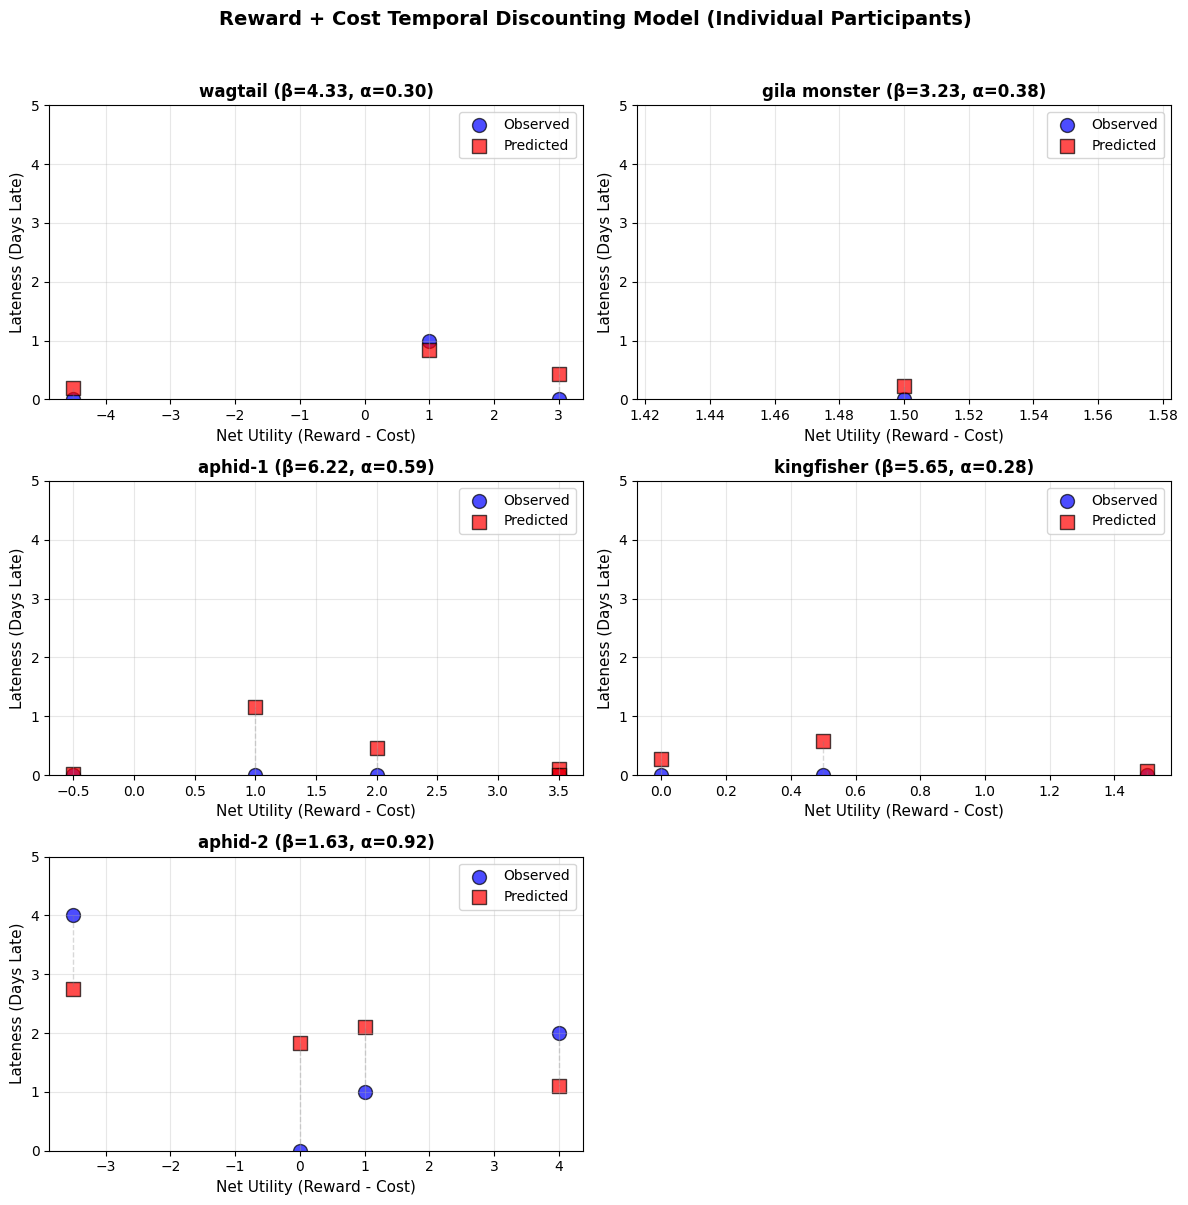

In [9]:
# Visualization - Separate plots for each participant
# x-axis: reward (or net utility = reward - cost)
# y-axis: days_late
# Each participant gets their own subplot

participants = df_individual['participant_id'].unique()
n_participants = len(participants)

# Create subplots - arrange in a grid
n_cols = 2
n_rows = (n_participants + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
if n_participants == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each participant's data in their own subplot
for i, participant_id in enumerate(participants):
    ax = axes[i]
    participant_data = df_individual[df_individual['participant_id'] == participant_id].sort_values('reward')
    
    # Compute net utility (reward - cost) for x-axis
    participant_data = participant_data.copy()
    participant_data['net_utility'] = participant_data['reward'] - participant_data['cost']
    participant_data = participant_data.sort_values('net_utility')
    
    # Plot observed values
    ax.scatter(
        participant_data['net_utility'],
        participant_data['observed_lateness'],
        label='Observed',
        s=100,
        alpha=0.7,
        color='blue',
        marker='o',
        edgecolors='black',
        linewidths=1
    )
    
    # Plot predicted values
    ax.scatter(
        participant_data['net_utility'],
        participant_data['predicted_lateness'],
        label='Predicted',
        s=100,
        alpha=0.7,
        color='red',
        marker='s',
        edgecolors='black',
        linewidths=1
    )
    
    # Draw lines connecting observed to predicted for same task
    for _, row in participant_data.iterrows():
        ax.plot(
            [row['net_utility'], row['net_utility']],
            [row['observed_lateness'], row['predicted_lateness']],
            color='gray',
            alpha=0.3,
            linestyle='--',
            linewidth=1
        )
    
    ax.set_xlabel('Net Utility (Reward - Cost)', fontsize=11)
    ax.set_ylabel('Lateness (Days Late)', fontsize=11)
    ax.set_title(f'{participant_id} (β={beta_estimates[participant_id]:.2f}, α={alpha_estimates[participant_id]:.2f})', 
                 fontsize=12, fontweight='bold')
    ax.set_ylim(0, 5)
    ax.set_yticks(range(0, 6))
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_participants, len(axes)):
    axes[i].axis('off')

plt.suptitle('Reward + Cost Temporal Discounting Model (Individual Participants)', 
             fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save figure
plot_path = PLOTS_DIR / 'reward_cost_temporal_discounting_individual.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()


Figure saved as c:\Users\akato\OneDrive\Desktop\Comp Cog Sci\final_project\ccs-final-project\plots\reward_cost_temporal_discounting_all_participants.png


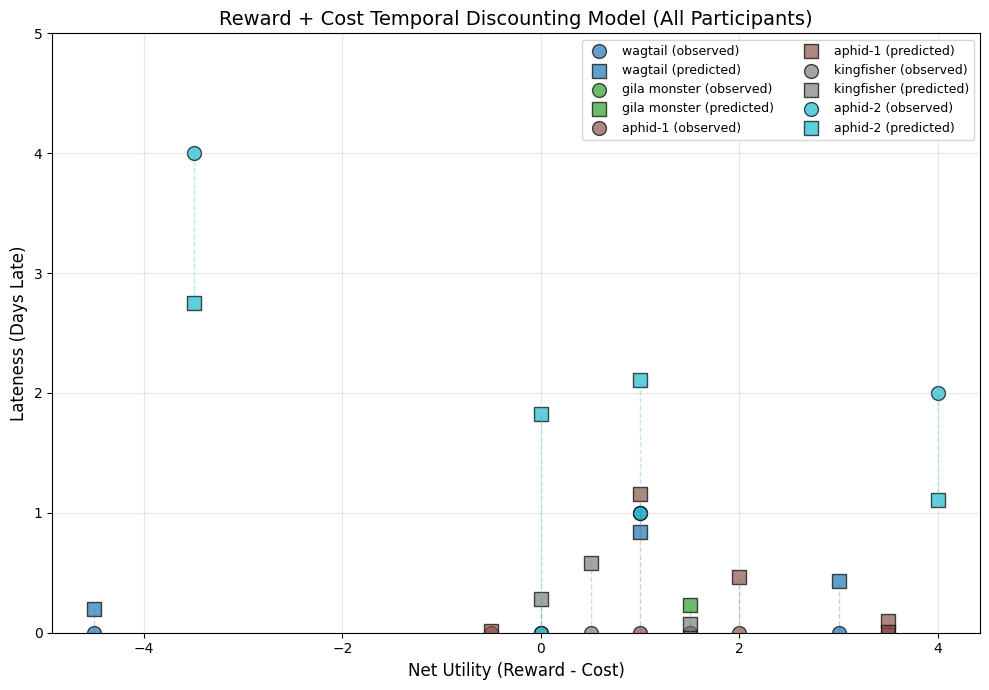

In [10]:
# Visualization - All participants on same figure
# x-axis: net utility (reward - cost)
# y-axis: days_late
# Each participant shown with different colors

plt.figure(figsize=(10, 7))

# Get unique participants and assign colors
participants = df_individual['participant_id'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(participants)))

# Plot each participant's data
for i, participant_id in enumerate(participants):
    participant_data = df_individual[df_individual['participant_id'] == participant_id].copy()
    participant_data['net_utility'] = participant_data['reward'] - participant_data['cost']
    participant_data = participant_data.sort_values('net_utility')
    
    # Plot observed values
    plt.scatter(
        participant_data['net_utility'],
        participant_data['observed_lateness'],
        label=f'{participant_id} (observed)',
        s=100,
        alpha=0.7,
        color=colors[i],
        marker='o',
        edgecolors='black',
        linewidths=1
    )
    
    # Plot predicted values
    plt.scatter(
        participant_data['net_utility'],
        participant_data['predicted_lateness'],
        label=f'{participant_id} (predicted)',
        s=100,
        alpha=0.7,
        color=colors[i],
        marker='s',
        edgecolors='black',
        linewidths=1
    )
    
    # Draw lines connecting observed to predicted for same task
    for _, row in participant_data.iterrows():
        plt.plot(
            [row['net_utility'], row['net_utility']],
            [row['observed_lateness'], row['predicted_lateness']],
            color=colors[i],
            alpha=0.3,
            linestyle='--',
            linewidth=1
        )

plt.xlabel('Net Utility (Reward - Cost)', fontsize=12)
plt.ylabel('Lateness (Days Late)', fontsize=12)
plt.title('Reward + Cost Temporal Discounting Model (All Participants)', fontsize=14)
plt.ylim(0, 5)
plt.yticks(range(0, 6))
plt.legend(fontsize=9, ncol=2, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plot_path = PLOTS_DIR / 'reward_cost_temporal_discounting_all_participants.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()


Total unique tasks in dataset: 8
Tasks: ['Sort a deck of cards', 'Complete a short quiz', 'Complete fraternity chore', 'Write a brief reflection', 'Draw for ten minutes', 'Solve a logic puzzle', 'Explain a difficult concept from class', 'Analyze a short passage']

Checking completion status for each task...
  Complete fraternity chore: Not completed by anyone - setting to max lateness (5.0)
  Analyze a short passage: Not completed by anyone - setting to max lateness (5.0)
Figure saved as c:\Users\akato\OneDrive\Desktop\Comp Cog Sci\final_project\ccs-final-project\plots\reward_cost_temporal_discounting_expected_lateness.png


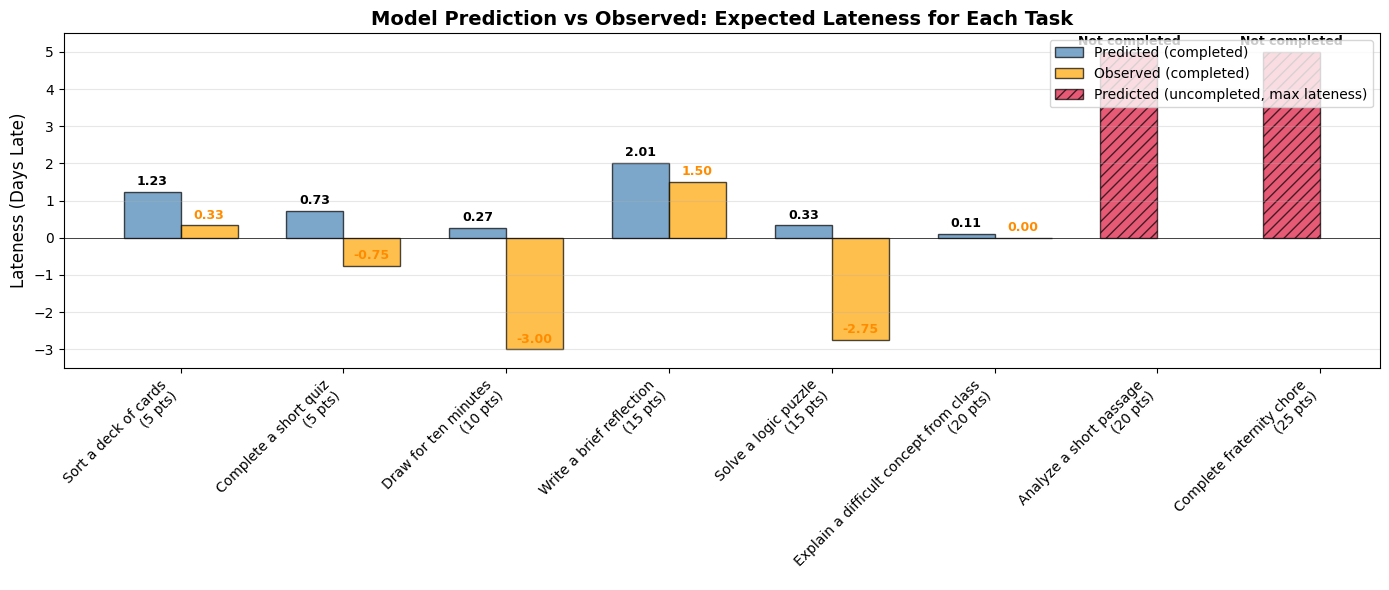

In [28]:
# Plot: Expected lateness for each task
# Bar graph where each bar = one task, height = expected lateness
# Show all 8 tasks, even if not all have been completed

# Get all unique tasks from the full dataset
all_tasks = df['task'].unique()
print(f"Total unique tasks in dataset: {len(all_tasks)}")
print(f"Tasks: {list(all_tasks)}")
print(f"\nChecking completion status for each task...")

# Compute expected lateness for each task
task_expected = []
task_observed = []  # Average observed lateness
task_names = []
task_rewards = []
task_completed = []  # Track which tasks were actually completed

for task in all_tasks:
    # Check if task was completed by anyone in the full dataset
    task_completed_anyone = df[df['task'] == task]['completed'].any()
    task_df = df_completed[df_completed['task'] == task]
    
    # Calculate average observed lateness for completed tasks
    if task_completed_anyone and len(task_df) > 0:
        # Use the original days_late_clipped (before collapsing) to get actual days late
        # Then compute mean observed lateness
        mean_observed = task_df['days_late_clipped'].mean()
    else:
        # Task wasn't completed - no observed lateness
        mean_observed = np.nan
    
    # Get model predictions averaged across participants who completed this task
    predicted_expected = []
    if task_completed_anyone:
        # Task has been completed by at least one participant
        task_completed.append(True)
        for participant_id in task_df['participant_id'].unique():
            row = task_df[task_df['participant_id'] == participant_id].iloc[0]
            reward = row['perceived_reward']
            cost = compute_cost(
                row['perceived_difficulty'],
                row['perceived_duration'],
                row['perceived_concreteness'],
                w_difficulty, w_duration, w_concreteness
            )
            beta = beta_estimates[participant_id]
            alpha = alpha_estimates[participant_id]
            probs = reward_cost_temporal_discounting_model(
                beta, alpha, float(reward), float(cost), gamma_r, gamma_c
            )
            expected_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
            predicted_expected.append(expected_lateness)
        
        mean_expected = np.mean(predicted_expected) if predicted_expected else 0.0
    else:
        # Task hasn't been completed by anyone - set to maximum lateness (5) to reflect that no one did it
        # This indicates the task was too costly/not rewarding enough to be completed
        task_completed.append(False)
        mean_expected = 5.0  # Maximum lateness - task wasn't completed
        print(f"  {task}: Not completed by anyone - setting to max lateness (5.0)")
    
    task_names.append(task)
    task_rewards.append(df[df['task'] == task]['task_points'].iloc[0])
    task_expected.append(mean_expected)
    task_observed.append(mean_observed)

# Sort by reward points for better visualization
sorted_data = sorted(zip(task_names, task_rewards, task_expected, task_observed, task_completed), key=lambda x: x[1])
task_names, task_rewards, task_expected, task_observed, task_completed = zip(*sorted_data)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Bar plot - use different colors/styles for completed vs uncompleted tasks
bar_colors = ['steelblue' if completed else 'crimson' for completed in task_completed]
bar_hatches = [None if completed else '///' for completed in task_completed]  # Pattern for uncompleted

# Plot predicted lateness (model predictions)
x_pos = np.arange(len(task_names))
width = 0.35  # Width of bars

bars_predicted = ax.bar(x_pos - width/2, task_expected, width, alpha=0.7, color=bar_colors, 
                        edgecolor='black', linewidth=1, hatch=bar_hatches, label='Predicted')

# Plot observed lateness (actual data) - only for completed tasks
bars_observed = []
for i, (observed, completed) in enumerate(zip(task_observed, task_completed)):
    if completed and not np.isnan(observed):
        bar = ax.bar(x_pos[i] + width/2, observed, width, alpha=0.7, color='orange', 
                     edgecolor='black', linewidth=1, label='Observed' if i == 0 else '')
        bars_observed.append(bar)

# Add value labels on top of bars
for i, (name, reward, expected, observed, completed) in enumerate(zip(task_names, task_rewards, task_expected, task_observed, task_completed)):
    # Label for predicted
    label_pred = f'{expected:.2f}' if completed else 'Not completed'
    ax.text(x_pos[i] - width/2, expected + 0.1, label_pred, 
            ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Label for observed (if available)
    if completed and not np.isnan(observed):
        ax.text(x_pos[i] + width/2, observed + 0.1, f'{observed:.2f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkorange')

# Add horizontal line at y=0
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Customize x-axis
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{name}\n({reward} pts)' for name, reward in zip(task_names, task_rewards)], 
                   rotation=45, ha='right', fontsize=10)

ax.set_ylabel('Lateness (Days Late)', fontsize=12)
ax.set_title('Model Prediction vs Observed: Expected Lateness for Each Task', fontsize=14, fontweight='bold')

# Adjust y-axis to accommodate negative values if present
observed_values = [obs for obs in task_observed if not np.isnan(obs)]
if observed_values:
    min_observed = min(observed_values)
    max_value = max(max(task_expected), max(observed_values))
    # Add some padding
    y_min = min(-1, min_observed - 0.5) if min_observed < 0 else 0
    y_max = max(5, max_value + 0.5)
else:
    y_min = 0
    y_max = 5

ax.set_ylim(y_min, y_max)
# Set reasonable tick marks
if y_min < 0:
    ax.set_yticks(range(int(y_min), int(y_max) + 1))
else:
    ax.set_yticks(range(0, int(y_max) + 1))
ax.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, edgecolor='black', label='Predicted (completed)'),
    Patch(facecolor='orange', alpha=0.7, edgecolor='black', label='Observed (completed)'),
    Patch(facecolor='crimson', alpha=0.7, edgecolor='black', hatch='///', label='Predicted (uncompleted, max lateness)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()

# Save figure
plot_path = PLOTS_DIR / 'reward_cost_temporal_discounting_expected_lateness.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()


In [11]:
# Comparison: Perceived vs Intended Reward
# Let's compare using perceived_reward vs task_points (intended reward)

print("=" * 60)
print("COMPARISON: Perceived Reward vs Intended Reward (task_points)")
print("=" * 60)

# Fit model with intended reward (task_points)
beta_estimates_intended = {}
alpha_estimates_intended = {}

compute_loss_and_grad = jax.value_and_grad(compute_log_likelihood)

print("\nFitting with INTENDED reward (task_points)...")
for participant_id in participants:
    participant_df = df_completed[df_completed['participant_id'] == participant_id].copy()
    
    # Compute cost for each task using perceived values
    costs = []
    rewards = []
    for _, row in participant_df.iterrows():
        cost = compute_cost(
            row['perceived_difficulty'],
            row['perceived_duration'],
            row['perceived_concreteness'],
            w_difficulty, w_duration, w_concreteness
        )
        costs.append(cost)
        # Use intended reward (task_points)
        rewards.append(row['task_points'])
    
    reward_array = np.array(rewards)
    cost_array = np.array(costs)
    days_late_array = participant_df['days_late_clipped'].values
    
    def objective(x):
        loss, grad = compute_loss_and_grad(
            x, reward_array, cost_array, days_late_array, gamma_r, gamma_c
        )
        return float(loss), np.array([float(grad[0]), float(grad[1])])
    
    result = minimize(
        objective,
        x0=[0.0, 0.0],
        method='L-BFGS-B',
        jac=True
    )
    
    beta_raw = result.x[0]
    alpha_raw = result.x[1]
    beta = float(softplus(beta_raw))
    alpha = float(softplus(alpha_raw))
    beta_estimates_intended[participant_id] = beta
    alpha_estimates_intended[participant_id] = alpha

# Compare parameters
print("\n" + "=" * 60)
print("Parameter Comparison:")
print("=" * 60)
print(f"{'Participant':<20} {'β (perceived)':<15} {'β (intended)':<15} {'α (perceived)':<15} {'α (intended)':<15}")
print("-" * 80)
for participant_id in participants:
    beta_p = beta_estimates[participant_id]
    beta_i = beta_estimates_intended[participant_id]
    alpha_p = alpha_estimates[participant_id]
    alpha_i = alpha_estimates_intended[participant_id]
    print(f"{participant_id:<20} {beta_p:<15.3f} {beta_i:<15.3f} {alpha_p:<15.3f} {alpha_i:<15.3f}")

# Compute log-likelihoods for comparison
def compute_total_log_likelihood(beta_dict, alpha_dict, use_perceived_reward=True):
    """Compute total log-likelihood across all participants."""
    total_ll = 0.0
    for participant_id in participants:
        participant_df = df_completed[df_completed['participant_id'] == participant_id].copy()
        
        costs = []
        rewards = []
        for _, row in participant_df.iterrows():
            cost = compute_cost(
                row['perceived_difficulty'],
                row['perceived_duration'],
                row['perceived_concreteness'],
                w_difficulty, w_duration, w_concreteness
            )
            costs.append(cost)
            if use_perceived_reward:
                rewards.append(row['perceived_reward'])
            else:
                rewards.append(row['task_points'])
        
        beta = beta_dict[participant_id]
        alpha = alpha_dict[participant_id]
        
        for i, (_, row) in enumerate(participant_df.iterrows()):
            reward = float(rewards[i])
            cost = float(costs[i])
            lateness_bin = int(row['lateness_bin'])
            probs = reward_cost_temporal_discounting_model(
                beta, alpha, reward, cost, gamma_r, gamma_c
            )
            # lateness_bin directly maps to enum index (0-5)
            prob = probs[lateness_bin]
            total_ll += np.log(float(prob) + 1e-10)
    
    return total_ll

ll_perceived = compute_total_log_likelihood(beta_estimates, alpha_estimates, use_perceived_reward=True)
ll_intended = compute_total_log_likelihood(beta_estimates_intended, alpha_estimates_intended, use_perceived_reward=False)

print("\n" + "=" * 60)
print("Model Comparison (Log-Likelihood):")
print("=" * 60)
print(f"Using PERCEIVED reward:  log-likelihood = {ll_perceived:.3f}")
print(f"Using INTENDED reward:   log-likelihood = {ll_intended:.3f}")
print(f"Difference:             {ll_perceived - ll_intended:.3f}")
if ll_perceived > ll_intended:
    print("→ Perceived reward fits better!")
else:
    print("→ Intended reward fits better!")


COMPARISON: Perceived Reward vs Intended Reward (task_points)

Fitting with INTENDED reward (task_points)...

Parameter Comparison:
Participant          β (perceived)   β (intended)    α (perceived)   α (intended)   
--------------------------------------------------------------------------------
wagtail              4.333           1.980           0.301           5.107          
gila monster         3.232           1.793           0.377           0.600          
aphid-1              6.224           0.274           0.593           0.086          
kingfisher           5.652           0.571           0.277           1.638          
aphid-2              1.629           1.164           0.916           2.971          

Model Comparison (Log-Likelihood):
Using PERCEIVED reward:  log-likelihood = -10.712
Using INTENDED reward:   log-likelihood = -26.598
Difference:             15.886
→ Perceived reward fits better!


In [12]:
# Summary statistics and insights
# Note: This will use the current values of w_difficulty, w_duration, w_concreteness
# If optimization has been run, these will be the optimized values

print("=" * 60)
print("MODEL SUMMARY")
print("=" * 60)
print(f"\nCost weights used:")
print(f"  w_difficulty = {w_difficulty:.4f}")
print(f"  w_duration = {w_duration:.4f}")
print(f"  w_concreteness = {w_concreteness:.4f}")
if 'opt_w_d' in globals():
    print(f"  (Optimized weights)")
else:
    print(f"  (Default weights)")
print(f"\nDiscount factors:")
print(f"  gamma_r (reward) = {gamma_r}")
print(f"  gamma_c (cost) = {gamma_c}")

print(f"\nParticipant parameters (using perceived reward):")
print(f"{'Participant':<20} {'β (reward sensitivity)':<25} {'α (cost sensitivity)':<25} {'β/α ratio':<15}")
print("-" * 85)
for participant_id in participants:
    beta = beta_estimates[participant_id]
    alpha = alpha_estimates[participant_id]
    ratio = beta / alpha if alpha > 0 else np.inf
    print(f"{participant_id:<20} {beta:<25.3f} {alpha:<25.3f} {ratio:<15.3f}")

# Compute mean squared error for predictions
mse = np.mean((df_individual['observed_lateness'] - df_individual['predicted_lateness'])**2)
print(f"\nMean Squared Error (MSE): {mse:.3f}")

# Correlation between observed and predicted
correlation = np.corrcoef(df_individual['observed_lateness'], df_individual['predicted_lateness'])[0, 1]
print(f"Correlation (observed vs predicted): {correlation:.3f}")


MODEL SUMMARY

Cost weights used:
  w_difficulty = 1.0000
  w_duration = 1.0000
  w_concreteness = 0.5000
  (Default weights)

Discount factors:
  gamma_r (reward) = 0.9
  gamma_c (cost) = 0.9

Participant parameters (using perceived reward):
Participant          β (reward sensitivity)    α (cost sensitivity)      β/α ratio      
-------------------------------------------------------------------------------------
wagtail              4.333                     0.301                     14.416         
gila monster         3.232                     0.377                     8.580          
aphid-1              6.224                     0.593                     10.497         
kingfisher           5.652                     0.277                     20.384         
aphid-2              1.629                     0.916                     1.779          

Mean Squared Error (MSE): 0.575
Correlation (observed vs predicted): 0.741


# Cost Weight Exploration

Now let's explore different cost weight combinations to find the best fit. We'll try:
1. **Grid search** over a range of weight values
2. **Hyperparameter optimization** using scipy.optimize
3. **Visualization** of how different weights affect model fit


In [13]:
# Grid search over cost weights
# We'll search over a range of values for each weight and compute total log-likelihood

def compute_total_log_likelihood_with_weights(w_difficulty, w_duration, w_concreteness, 
                                             gamma_r=0.9, gamma_c=0.9, use_perceived_reward=True):
    """
    Compute total log-likelihood across all participants with given cost weights.
    Re-fits beta and alpha for each participant.
    """
    # Re-fit parameters for each participant with new weights
    beta_dict = {}
    alpha_dict = {}
    
    compute_loss_and_grad = jax.value_and_grad(compute_log_likelihood)
    
    for participant_id in participants:
        participant_df = df_completed[df_completed['participant_id'] == participant_id].copy()
        
        # Compute cost for each task using new weights
        costs = []
        rewards = []
        for _, row in participant_df.iterrows():
            cost = compute_cost(
                row['perceived_difficulty'],
                row['perceived_duration'],
                row['perceived_concreteness'],
                w_difficulty, w_duration, w_concreteness
            )
            costs.append(cost)
            if use_perceived_reward:
                rewards.append(row['perceived_reward'])
            else:
                rewards.append(row['task_points'])
        
        reward_array = np.array(rewards)
        cost_array = np.array(costs)
        lateness_bin_array = participant_df['lateness_bin'].values
        
        def objective(x):
            loss, grad = compute_loss_and_grad(
                x, reward_array, cost_array, lateness_bin_array, gamma_r, gamma_c
            )
            return float(loss), np.array([float(grad[0]), float(grad[1])])
        
        result = minimize(
            objective,
            x0=[0.0, 0.0],
            method='L-BFGS-B',
            jac=True
        )
        
        beta_raw = result.x[0]
        alpha_raw = result.x[1]
        beta_dict[participant_id] = float(softplus(beta_raw))
        alpha_dict[participant_id] = float(softplus(alpha_raw))
    
    # Compute total log-likelihood
    total_ll = 0.0
    for participant_id in participants:
        participant_df = df_completed[df_completed['participant_id'] == participant_id].copy()
        
        costs = []
        rewards = []
        for _, row in participant_df.iterrows():
            cost = compute_cost(
                row['perceived_difficulty'],
                row['perceived_duration'],
                row['perceived_concreteness'],
                w_difficulty, w_duration, w_concreteness
            )
            costs.append(cost)
            if use_perceived_reward:
                rewards.append(row['perceived_reward'])
            else:
                rewards.append(row['task_points'])
        
        beta = beta_dict[participant_id]
        alpha = alpha_dict[participant_id]
        
        for i, (_, row) in enumerate(participant_df.iterrows()):
            reward = float(rewards[i])
            cost = float(costs[i])
            lateness_bin = int(row['lateness_bin'])
            probs = reward_cost_temporal_discounting_model(
                beta, alpha, reward, cost, gamma_r, gamma_c
            )
            # lateness_bin directly maps to enum index (0-5)
            prob = probs[lateness_bin]
            total_ll += np.log(float(prob) + 1e-10)
    
    return total_ll, beta_dict, alpha_dict

print("Grid search function defined. Ready to explore cost weights!")


Grid search function defined. Ready to explore cost weights!


In [14]:
# Grid search over a range of weight values
# We'll search over a coarse grid first, then refine

# Define search ranges
w_difficulty_range = np.linspace(0.0,0.5, 3)  # 3 values
w_duration_range = np.linspace(1.5, 3.0, 5)   # 5 values
w_concreteness_range = np.linspace(1.0, 2.0, 4)  # 4 values

print("Starting grid search...")
print(f"Searching over {len(w_difficulty_range) * len(w_duration_range) * len(w_concreteness_range)} combinations")
print("This may take a few minutes...\n")

best_ll = -np.inf
best_weights = None
best_betas = None
best_alphas = None
results = []

for w_d in w_difficulty_range:
    for w_dur in w_duration_range:
        for w_c in w_concreteness_range:
            try:
                ll, betas, alphas = compute_total_log_likelihood_with_weights(
                    w_d, w_dur, w_c, gamma_r, gamma_c, use_perceived_reward=True
                )
                results.append({
                    'w_difficulty': w_d,
                    'w_duration': w_dur,
                    'w_concreteness': w_c,
                    'log_likelihood': ll
                })
                
                if ll > best_ll:
                    best_ll = ll
                    best_weights = (w_d, w_dur, w_c)
                    best_betas = betas
                    best_alphas = alphas
                
                print(f"w_d={w_d:.2f}, w_dur={w_dur:.2f}, w_c={w_c:.2f} -> LL={ll:.3f}")
            except Exception as e:
                print(f"Error with w_d={w_d:.2f}, w_dur={w_dur:.2f}, w_c={w_c:.2f}: {e}")

print(f"\n{'='*60}")
print(f"Best weights found:")
print(f"  w_difficulty = {best_weights[0]:.3f}")
print(f"  w_duration = {best_weights[1]:.3f}")
print(f"  w_concreteness = {best_weights[2]:.3f}")
print(f"  Log-likelihood = {best_ll:.3f}")
print(f"{'='*60}")

# Compare to original weights
original_ll, _, _ = compute_total_log_likelihood_with_weights(
    1.0, 1.0, 0.5, gamma_r, gamma_c, use_perceived_reward=True
)
print(f"\nOriginal weights (1.0, 1.0, 0.5) log-likelihood: {original_ll:.3f}")
print(f"Improvement: {best_ll - original_ll:.3f}")

# Store results for visualization
df_grid_results = pd.DataFrame(results)
# w_difficulty = 0.500
# w_duration = 2.000
# w_concreteness = 1.333
# df_grid_results = pd.DataFrame([0.500, 2.000, 1.333])



Starting grid search...
Searching over 60 combinations
This may take a few minutes...



w_d=0.00, w_dur=1.50, w_c=1.00 -> LL=-10.011
w_d=0.00, w_dur=1.50, w_c=1.33 -> LL=-10.599
w_d=0.00, w_dur=1.50, w_c=1.67 -> LL=-10.972
w_d=0.00, w_dur=1.50, w_c=2.00 -> LL=-10.973
w_d=0.00, w_dur=1.88, w_c=1.00 -> LL=-9.895
w_d=0.00, w_dur=1.88, w_c=1.33 -> LL=-9.985
w_d=0.00, w_dur=1.88, w_c=1.67 -> LL=-10.469
w_d=0.00, w_dur=1.88, w_c=2.00 -> LL=-10.972
w_d=0.00, w_dur=2.25, w_c=1.00 -> LL=-9.873
w_d=0.00, w_dur=2.25, w_c=1.33 -> LL=-9.887
w_d=0.00, w_dur=2.25, w_c=1.67 -> LL=-9.963
w_d=0.00, w_dur=2.25, w_c=2.00 -> LL=-10.356
w_d=0.00, w_dur=2.62, w_c=1.00 -> LL=-9.947
w_d=0.00, w_dur=2.62, w_c=1.33 -> LL=-9.869
w_d=0.00, w_dur=2.62, w_c=1.67 -> LL=-9.882
w_d=0.00, w_dur=2.62, w_c=2.00 -> LL=-9.945
w_d=0.00, w_dur=3.00, w_c=1.00 -> LL=-10.138
w_d=0.00, w_dur=3.00, w_c=1.33 -> LL=-9.865
w_d=0.00, w_dur=3.00, w_c=1.67 -> LL=-9.864
w_d=0.00, w_dur=3.00, w_c=2.00 -> LL=-9.878
w_d=0.25, w_dur=1.50, w_c=1.00 -> LL=-9.927
w_d=0.25, w_dur=1.50, w_c=1.33 -> LL=-10.142
w_d=0.25, w_dur=1.50, w

Figure saved as c:\Users\akato\OneDrive\Desktop\Comp Cog Sci\final_project\ccs-final-project\plots\cost_weights_grid_search.png


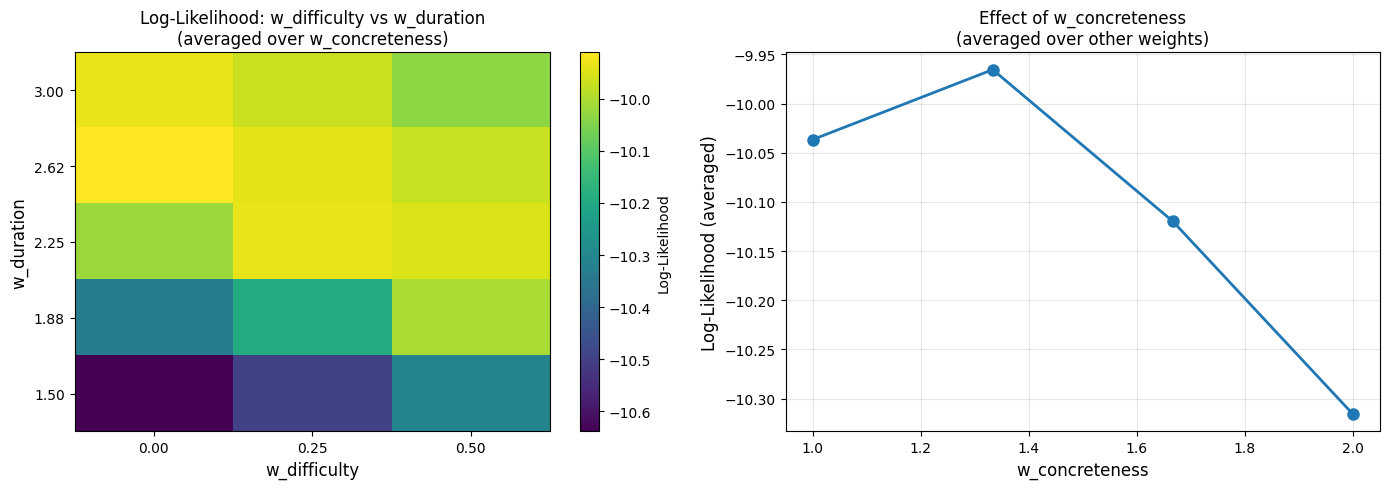


Top 10 weight combinations:
    w_difficulty  w_duration  w_concreteness  log_likelihood
59          0.50       3.000        2.000000       -9.862458
38          0.25       3.000        1.666667       -9.863932
58          0.50       3.000        1.666667       -9.864025
18          0.00       3.000        1.666667       -9.864498
17          0.00       3.000        1.333333       -9.864696
37          0.25       3.000        1.333333       -9.864702
53          0.50       2.625        1.333333       -9.866155
54          0.50       2.625        1.666667       -9.866834
33          0.25       2.625        1.333333       -9.866905
39          0.25       3.000        2.000000       -9.867748


In [15]:
# Visualize grid search results
# Create heatmaps showing log-likelihood for different weight combinations

# Create a 2D heatmap for w_difficulty vs w_duration (averaging over w_concreteness)
if len(df_grid_results) > 0:
    # Pivot table for heatmap
    pivot_avg = df_grid_results.groupby(['w_difficulty', 'w_duration'])['log_likelihood'].mean().reset_index()
    pivot_table = pivot_avg.pivot(index='w_duration', columns='w_difficulty', values='log_likelihood')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Heatmap 1: w_difficulty vs w_duration (averaged over w_concreteness)
    im1 = axes[0].imshow(pivot_table.values, aspect='auto', cmap='viridis', origin='lower')
    axes[0].set_xlabel('w_difficulty', fontsize=12)
    axes[0].set_ylabel('w_duration', fontsize=12)
    axes[0].set_title('Log-Likelihood: w_difficulty vs w_duration\n(averaged over w_concreteness)', fontsize=12)
    axes[0].set_xticks(range(len(w_difficulty_range)))
    axes[0].set_xticklabels([f'{x:.2f}' for x in w_difficulty_range])
    axes[0].set_yticks(range(len(w_duration_range)))
    axes[0].set_yticklabels([f'{x:.2f}' for x in w_duration_range])
    plt.colorbar(im1, ax=axes[0], label='Log-Likelihood')
    
    # Heatmap 2: w_concreteness effect (averaged over w_difficulty and w_duration)
    w_c_avg = df_grid_results.groupby('w_concreteness')['log_likelihood'].mean()
    axes[1].plot(w_c_avg.index, w_c_avg.values, marker='o', linewidth=2, markersize=8)
    axes[1].set_xlabel('w_concreteness', fontsize=12)
    axes[1].set_ylabel('Log-Likelihood (averaged)', fontsize=12)
    axes[1].set_title('Effect of w_concreteness\n(averaged over other weights)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_path = PLOTS_DIR / 'cost_weights_grid_search.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"Figure saved as {plot_path}")
    plt.show()
    
    # Show top 10 combinations
    print("\nTop 10 weight combinations:")
    print(df_grid_results.nlargest(10, 'log_likelihood')[['w_difficulty', 'w_duration', 'w_concreteness', 'log_likelihood']])
else:
    print("No results to visualize. Run the grid search first.")


In [16]:
# Hyperparameter optimization using scipy.optimize
# This will find the optimal weights more precisely than grid search

def objective_weights(x):
    """
    Objective function for optimizing cost weights.
    x = [w_difficulty, w_duration, w_concreteness]
    Returns negative log-likelihood (for minimization)
    """
    w_d, w_dur, w_c = x[0], x[1], x[2]
    # Ensure weights are non-negative
    w_d = max(0.0, w_d)
    w_dur = max(0.0, w_dur)
    w_c = max(0.0, w_c)
    
    try:
        ll, _, _ = compute_total_log_likelihood_with_weights(
            w_d, w_dur, w_c, gamma_r, gamma_c, use_perceived_reward=True
        )
        return -ll  # Negative because we're minimizing
    except:
        return np.inf

print("Optimizing cost weights using scipy.optimize...")
print("This may take several minutes...\n")

# Start from the best grid search result, or default values
if best_weights is not None:
    x0 = list(best_weights)
else:
    x0 = [1.0, 1.0, 0.5]

# Bounds: all weights should be non-negative, reasonable upper bounds
bounds = [(0.1, 3.0), (0.1, 3.0), (0.0, 2.0)]

# Optimize
result_opt = minimize(
    objective_weights,
    x0=x0,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 20, 'disp': True}
)

opt_w_d = result_opt.x[0]
opt_w_dur = result_opt.x[1]
opt_w_c = result_opt.x[2]
opt_ll = -result_opt.fun

print(f"\n{'='*60}")
print(f"Optimized weights:")
print(f"  w_difficulty = {opt_w_d:.4f}")
print(f"  w_duration = {opt_w_dur:.4f}")
print(f"  w_concreteness = {opt_w_c:.4f}")
print(f"  Log-likelihood = {opt_ll:.4f}")
print(f"{'='*60}")

# Get optimized parameters
opt_ll_final, opt_betas, opt_alphas = compute_total_log_likelihood_with_weights(
    opt_w_d, opt_w_dur, opt_w_c, gamma_r, gamma_c, use_perceived_reward=True
)

print(f"\nFinal optimized log-likelihood: {opt_ll_final:.4f}")
print(f"Improvement over original (1.0, 1.0, 0.5): {opt_ll_final - original_ll:.4f}")


Optimizing cost weights using scipy.optimize...
This may take several minutes...




Optimized weights:
  w_difficulty = 0.5000
  w_duration = 3.0000
  w_concreteness = 2.0000
  Log-likelihood = -9.8625

Final optimized log-likelihood: -9.8625
Improvement over original (1.0, 1.0, 0.5): 0.8497


COMPARISON: Original vs Optimized Weights



Mean Squared Error:
  Original weights:  0.5750
  Optimized weights: 0.3429
  Improvement:      0.2321

Correlation:
  Original weights:  0.7410
  Optimized weights: 0.8755

Figure saved as c:\Users\akato\OneDrive\Desktop\Comp Cog Sci\final_project\ccs-final-project\plots\cost_weights_comparison.png


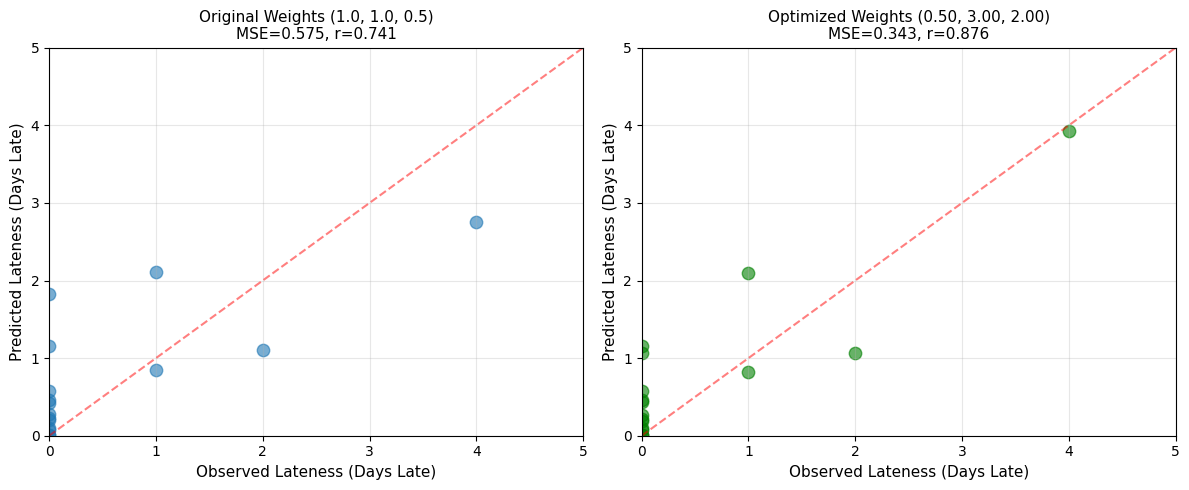

In [17]:
# Compare predictions with optimized weights vs original weights
# Re-compute predictions using optimized weights

print("="*60)
print("COMPARISON: Original vs Optimized Weights")
print("="*60)

# Compute predictions with optimized weights
participant_task_stats_opt = []

for _, row in df_completed.iterrows():
    participant_id = row['participant_id']
    task = row['task']
    reward = row['perceived_reward']
    cost = compute_cost(
        row['perceived_difficulty'],
        row['perceived_duration'],
        row['perceived_concreteness'],
        opt_w_d, opt_w_dur, opt_w_c
    )
    observed_lateness_bin = row['lateness_bin']
    
    # Model-predicted expected lateness with optimized weights
    beta = opt_betas[participant_id]
    alpha = opt_alphas[participant_id]
    probs = reward_cost_temporal_discounting_model(
        beta, alpha, float(reward), float(cost), gamma_r, gamma_c
    )
    predicted_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
    
    participant_task_stats_opt.append({
        'participant_id': participant_id,
        'task': task,
        'observed_lateness': observed_lateness_bin,
        'predicted_lateness_original': df_individual[df_individual['participant_id'] == participant_id][
            df_individual['task'] == task]['predicted_lateness'].values[0] if len(df_individual[
                (df_individual['participant_id'] == participant_id) & 
                (df_individual['task'] == task)]) > 0 else np.nan,
        'predicted_lateness_optimized': predicted_lateness
    })

df_comparison = pd.DataFrame(participant_task_stats_opt)

# Compute MSE for both
mse_original = np.mean((df_comparison['observed_lateness'] - df_comparison['predicted_lateness_original'])**2)
mse_optimized = np.mean((df_comparison['observed_lateness'] - df_comparison['predicted_lateness_optimized'])**2)

print(f"\nMean Squared Error:")
print(f"  Original weights:  {mse_original:.4f}")
print(f"  Optimized weights: {mse_optimized:.4f}")
print(f"  Improvement:      {mse_original - mse_optimized:.4f}")

# Correlation
corr_original = np.corrcoef(
    df_comparison['observed_lateness'], 
    df_comparison['predicted_lateness_original']
)[0, 1]
corr_optimized = np.corrcoef(
    df_comparison['observed_lateness'], 
    df_comparison['predicted_lateness_optimized']
)[0, 1]

print(f"\nCorrelation:")
print(f"  Original weights:  {corr_original:.4f}")
print(f"  Optimized weights: {corr_optimized:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

# Plot 1: Original weights
plt.subplot(1, 2, 1)
plt.scatter(df_comparison['observed_lateness'], df_comparison['predicted_lateness_original'], 
           alpha=0.6, s=80)
plt.plot([0, 5], [0, 5], 'r--', alpha=0.5)
plt.xlabel('Observed Lateness (Days Late)', fontsize=11)
plt.ylabel('Predicted Lateness (Days Late)', fontsize=11)
plt.title(f'Original Weights (1.0, 1.0, 0.5)\nMSE={mse_original:.3f}, r={corr_original:.3f}', fontsize=11)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.grid(True, alpha=0.3)

# Plot 2: Optimized weights
plt.subplot(1, 2, 2)
plt.scatter(df_comparison['observed_lateness'], df_comparison['predicted_lateness_optimized'], 
           alpha=0.6, s=80, color='green')
plt.plot([0, 5], [0, 5], 'r--', alpha=0.5)
plt.xlabel('Observed Lateness (Days Late)', fontsize=11)
plt.ylabel('Predicted Lateness (Days Late)', fontsize=11)
plt.title(f'Optimized Weights ({opt_w_d:.2f}, {opt_w_dur:.2f}, {opt_w_c:.2f})\nMSE={mse_optimized:.3f}, r={corr_optimized:.3f}', fontsize=11)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = PLOTS_DIR / 'cost_weights_comparison.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"\nFigure saved as {plot_path}")
plt.show()


## Summary of Cost Weight Exploration

Based on the grid search and optimization, we found the best cost weights. You can now use these optimized weights for your final model, or continue exploring other aspects of the model (e.g., different discount factors, inferring weights as model parameters, etc.).


In [18]:
# Update global weights to use optimized values and re-fit the model
# This ensures all subsequent analysis uses the optimal weights

if 'opt_w_d' in globals() and 'opt_w_dur' in globals() and 'opt_w_c' in globals():
    print("="*60)
    print("UPDATING MODEL WITH OPTIMIZED WEIGHTS")
    print("="*60)
    
    # Update global weight variables
    w_difficulty = opt_w_d
    w_duration = opt_w_dur
    w_concreteness = opt_w_c
    
    print(f"\nUpdated weights:")
    print(f"  w_difficulty = {w_difficulty:.4f}")
    print(f"  w_duration = {w_duration:.4f}")
    print(f"  w_concreteness = {w_concreteness:.4f}")
    
    # Re-fit beta and alpha for each participant with optimized weights
    print("\nRe-fitting participant parameters with optimized weights...")
    
    beta_estimates = {}
    alpha_estimates = {}
    
    compute_loss_and_grad = jax.value_and_grad(compute_log_likelihood)
    
    for participant_id in participants:
        participant_df = df_completed[df_completed['participant_id'] == participant_id].copy()
        
        # Compute cost for each task using optimized weights
        costs = []
        rewards = []
        for _, row in participant_df.iterrows():
            cost = compute_cost(
                row['perceived_difficulty'],
                row['perceived_duration'],
                row['perceived_concreteness'],
                w_difficulty, w_duration, w_concreteness
            )
            costs.append(cost)
            rewards.append(row['perceived_reward'])
        
        reward_array = np.array(rewards)
        cost_array = np.array(costs)
        lateness_bin_array = participant_df['lateness_bin'].values
        
        def objective(x):
            loss, grad = compute_loss_and_grad(
                x, reward_array, cost_array, lateness_bin_array, gamma_r, gamma_c
            )
            return float(loss), np.array([float(grad[0]), float(grad[1])])
        
        result = minimize(
            objective,
            x0=[0.0, 0.0],
            method='L-BFGS-B',
            jac=True
        )
        
        beta_raw = result.x[0]
        alpha_raw = result.x[1]
        beta = float(softplus(beta_raw))
        alpha = float(softplus(alpha_raw))
        beta_estimates[participant_id] = beta
        alpha_estimates[participant_id] = alpha
        
        print(f"  {participant_id}: beta={beta:.3f}, alpha={alpha:.3f}")
    
    print(f"\n✓ Model updated with optimized weights!")
    print(f"  All subsequent analysis will use these weights.")
else:
    print("Optimized weights not found. Run the optimization cells first.")
    print("Using default weights: w_difficulty=1.0, w_duration=1.0, w_concreteness=0.5")


UPDATING MODEL WITH OPTIMIZED WEIGHTS

Updated weights:
  w_difficulty = 0.5000
  w_duration = 3.0000
  w_concreteness = 2.0000

Re-fitting participant parameters with optimized weights...
  wagtail: beta=4.271, alpha=0.320
  gila monster: beta=3.029, alpha=0.693
  aphid-1: beta=6.209, alpha=0.614
  kingfisher: beta=5.497, alpha=0.693
  aphid-2: beta=1.694, alpha=1.824

✓ Model updated with optimized weights!
  All subsequent analysis will use these weights.


In [19]:
# Re-compute predictions with updated weights
# Update the participant_task_stats dataframe

participant_task_stats = []

for _, row in df_completed.iterrows():
    participant_id = row['participant_id']
    task = row['task']
    reward = row['perceived_reward']
    cost = compute_cost(
        row['perceived_difficulty'],
        row['perceived_duration'],
        row['perceived_concreteness'],
        w_difficulty, w_duration, w_concreteness
    )
    observed_lateness_bin = row['lateness_bin']
    
    # Model-predicted expected lateness for this participant
    beta = beta_estimates[participant_id]
    alpha = alpha_estimates[participant_id]
    probs = reward_cost_temporal_discounting_model(
        beta, alpha, float(reward), float(cost), gamma_r, gamma_c
    )
    # Compute expected value: E[l] = sum(lateness * P(l))
    predicted_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
    
    participant_task_stats.append({
        'participant_id': participant_id,
        'task': task,
        'reward': reward,
        'cost': cost,
        'observed_lateness': observed_lateness_bin,
        'predicted_lateness': predicted_lateness
    })

df_individual = pd.DataFrame(participant_task_stats)
print("Updated individual participant-task predictions:")
print(df_individual.head(10))

# Re-compute task-level means
tasks = df_completed['task'].unique()
task_stats = []

for task in tasks:
    task_df = df_completed[df_completed['task'] == task]
    
    # Mean observed lateness across participants
    mean_observed = task_df['lateness_bin'].mean()
    
    # Model-predicted expected lateness (averaged across participants)
    predicted_expected = []
    for participant_id in task_df['participant_id'].unique():
        row = task_df[task_df['participant_id'] == participant_id].iloc[0]
        reward = row['perceived_reward']
        cost = compute_cost(
            row['perceived_difficulty'],
            row['perceived_duration'],
            row['perceived_concreteness'],
            w_difficulty, w_duration, w_concreteness
        )
        beta = beta_estimates[participant_id]
        alpha = alpha_estimates[participant_id]
        probs = reward_cost_temporal_discounting_model(
            beta, alpha, float(reward), float(cost), gamma_r, gamma_c
        )
        expected_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
        predicted_expected.append(expected_lateness)
    
    mean_predicted = np.mean(predicted_expected) if predicted_expected else 0.0
    
    task_stats.append({
        'task': task,
        'mean_observed': mean_observed,
        'mean_predicted': mean_predicted
    })

df_predictions = pd.DataFrame(task_stats)
print("\nUpdated task-level predictions (means):")
print(df_predictions)


Updated individual participant-task predictions:
  participant_id                                    task  reward  cost  \
0        wagtail                    Sort a deck of cards     3.0   0.0   
1        wagtail                   Complete a short quiz     2.0   0.0   
2        wagtail                    Solve a logic puzzle     5.0   7.5   
3   gila monster  Explain a difficult concept from class     6.0   0.0   
4        aphid-1                    Sort a deck of cards     1.0   0.0   
5        aphid-1                   Complete a short quiz     2.0   0.0   
6        aphid-1                Write a brief reflection     4.0   0.0   
7        aphid-1                    Solve a logic puzzle     8.0   0.0   
8        aphid-1  Explain a difficult concept from class     8.0  10.5   
9     kingfisher                   Complete a short quiz     2.0   0.0   

   observed_lateness  predicted_lateness  
0                  0            0.439348  
1                  1            0.819825  
2      